# <center>`STS-TCIA Radiomic features extraction through MRI tumor and segmentation`</center>


In this notebook we show how to extract radiomics features from Magnetic Resonance Images (MRI).
<br><br>
Radiomics features extraction is done using PyRadiomics, an open-source radiomics library written in python.
<br>
https://www.radiomics.io/pyradiomics.html
<br><br>
The MRI dataset comes from the Soft Tissue Sarcoma (STS) collection, hosted on The Cancer Imaging Archive (TCIA),  a service which de-identifies and hosts a large archive of medical images of cancer accessible for public download.
<br>
https://wiki.cancerimagingarchive.net/display/Public/Soft-tissue-Sarcoma
<br>


- Here we're importing some modules we'll work with, and also the `featureextractor` submodule from `radiomics`.

In [81]:
import os
import logging
import radiomics
from radiomics import featureextractor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json

gen_new_temp_STS_TCIA = False


- We're setting the `featureextractor` to receive the `sts-settings1.yaml` customized file, instad of the default `.yaml` file. The `sts-settings1.yaml` must also be configured to normalize the image data before the `extractor` generates the features.

In [82]:
radiomics.setVerbosity(logging.ERROR)

paramFile = "sts-settings1.yaml"
paramPath = os.path.join("settings", paramFile)
print("Parameter file:", paramPath)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print("Extraction parameters:\n\t", extractor.settings)
print("Enabled filters:\n\t", extractor.enabledImagetypes)
print("Enabled features:\n\t", extractor.enabledFeatures)


Parameter file: settings/sts-settings1.yaml
Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': [3, 3, 3], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelArrayShift': 300, 'binWidth': 10}
Enabled filters:
	 {'Original': {}, 'LoG': {'sigma': [3.0, 5.0]}, 'Wavelet': {}}
Enabled features:
	 {'shape': None, 'firstorder': None, 'glcm': None, 'glrlm': None, 'glszm': None, 'gldm': None, 'ngtdm': None}


- The variable `data_root` is set to be the path to `STS` data folder. WHich contains all STS tumor area and corresponding labels from the TCIA public dataset https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=21266533


In [13]:
data_root = os.path.join('..', 'data', 'STS')

- We build the `walk_files` dataframe containing the correspoding path to `label` and `image` `.nrrd` files for each patient image `T1` and `STIR` or `T2FS`.

In [14]:
walk_files = pd.DataFrame(
    columns=["provider", "patient", "image_type", "walk_LABEL", "walk_IMAGE"])


labelSuffix = '-label'
filesExtension = '.nrrd'


for provider in os.listdir(data_root):
    walk_provider = os.path.join(data_root, provider)
    if os.path.isdir(walk_provider) and os.listdir(walk_provider):
        for patient in os.listdir(walk_provider):
            walk_patient = os.path.join(walk_provider, patient)
            if os.path.isdir(walk_patient) and os.listdir(walk_patient):
                for image_type in os.listdir(walk_patient):
                    walk_image_type = os.path.join(walk_patient, image_type)
                    if os.path.isdir(walk_image_type) and os.listdir(walk_image_type):
                        for file in os.listdir(walk_image_type):
                            if not os.path.isdir(file):
                                walk_file = os.path.join(walk_image_type, file)
                                if file.endswith(labelSuffix + filesExtension):
                                    walk_LABEL_file = walk_file
                                elif file.endswith(filesExtension):
                                    walk_IMAGE_file = walk_file
                        walk_files.loc[len(walk_files)] = [
                            provider, patient, image_type, walk_LABEL_file, walk_IMAGE_file]


walk_files


,provider,patient,image_type,walk_LABEL,walk_IMAGE


- Upon the `walk_files` dataframe, we could execute the feature `extractor`, which receives each image-label pair to build and evaluate the features for each `case_ID`. We stored all data in the `df_sts_tcia_rad` dataframe for each patient's `case_ID` (51*2=102 cases in total), which contains ***ALL the generated features*** in the columns.

In [5]:
if gen_new_temp_STS_TCIA:
    df_sts_tcia_rad = pd.DataFrame()
    df_sts_tcia_rad["case_ID"] = walk_files.provider + \
        "-"+walk_files.patient+"-"+walk_files.image_type
    df_sts_tcia_rad["case_ProviderID"] = walk_files.provider
    df_sts_tcia_rad["case_PatientID"] = walk_files.patient
    df_sts_tcia_rad["case_ImageType"] = walk_files.image_type

    df_sts_tcia_rad.set_index("case_ID", inplace=True)
    for index, label_path, image_path in zip(df_sts_tcia_rad.index, walk_files.walk_LABEL, walk_files.walk_IMAGE):
        radiomics = extractor.execute(image_path, label_path)
        for rad_key, rad_val in radiomics.items():
            if isinstance(rad_val, dict):
                df_sts_tcia_rad.loc[index, rad_key] = json.dumps(rad_val)
            elif isinstance(rad_val, tuple):
                df_sts_tcia_rad.loc[index, rad_key] = str(rad_val)
            else:
                df_sts_tcia_rad.loc[index, rad_key] = rad_val


- Temporary .csv conversion just to save the runned `df_sts_tcia_rad` dataframe (~5min running)

In [6]:
if gen_new_temp_STS_TCIA:
    file_name = "Temp_STS-TCIA.csv"
    df_sts_tcia_rad.to_csv(file_name)


- Now, we start by opening the `temporary file`

In [84]:
file_name = "Temp_STS-TCIA.csv"
df_sts_tcia_rad = pd.read_csv(os.path.join('csv',file_name))
df_sts_tcia_rad = df_sts_tcia_rad.sort_values(
    ["case_PatientID", "case_ImageType"])
df_sts_tcia_rad.drop(columns=['case_ID'], inplace=True)
df_sts_tcia_rad.head(5)


,case_ProviderID,case_PatientID,case_ImageType,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
11,TCIA,STS_001,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.382355,0.014371,0.111562,13.895895,0.002196,4.370039,0.000824,301.427279,0.046065,0.190421
10,TCIA,STS_001,T2FS,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.000783,0.000306,0.623462,4077.229667,0.000234,0.098624,0.000907,54522.134897,0.365681,5.735231
69,TCIA,STS_002,STIR,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.005826,0.001565,0.713815,7702.367375,0.000616,0.006910,0.009653,213222.857334,0.815927,261.107140
68,TCIA,STS_002,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.184798,0.007644,0.283175,256.102692,0.002118,0.111926,0.008068,4598.211806,0.165676,15.788664
57,TCIA,STS_003,STIR,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.001594,0.001085,0.665096,5362.708021,0.000985,0.014839,0.004550,77016.824576,0.534899,35.008041


In [92]:
df_sts_tcia_rad.groupby(['case_ImageType']).count()

,case_ProviderID,case_PatientID,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
case_ImageType,,,,,,,,,,,,,,,,,,,,,
STIR,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
T1,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
T2FS,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


In [8]:
def remove_cols(DataFrame, string):
    """Remover colunas com uma string no nome

    Args:
        DataFrame (DataFrame): Dataframe que sera removido
        string (str): texto para buscar colunas para remover

    Returns:
        DataFrame: Dataframe sem colunas desejadas
    """
    list_cols = list(
        col for col in DataFrame.columns if col.startswith(string))
    return DataFrame.drop(list_cols, axis=1)


def tag_cols(data, prefix, excepts):
    """Adicionar tag nas colunas

    Args:
        data (DataFrame): DataFrame que sera colocado tag
        prefix (str): tag que será adicionada
        excepts (str): Colunas que não terão tags

    Returns:
        _type_: _description_
    """
    data.columns = [col if col.startswith(
        excepts) else prefix+"_"+col for col in data.columns]
    return data


In [9]:
data = remove_cols(df_sts_tcia_rad, "diagnostics_")

data_t1 = data.loc[data.case_ImageType == "T1"]
tag_cols(data_t1, "T1", "case_")
data_t1 = data_t1.drop(columns=["case_ImageType"])

data_fs = data.loc[data.case_ImageType != 'T1']
tag_cols(data_fs, "FS", "case_")
data_fs = data_fs.drop(columns=['case_ProviderID', 'case_ImageType'])


In [10]:
df_sts_tcia_rad_merged = pd.merge(
    data_t1, data_fs, left_on='case_PatientID', right_on='case_PatientID')

df_sts_tcia_rad_merged.head(5)


,case_ProviderID,case_PatientID,T1_original_shape_Elongation,T1_original_shape_Flatness,T1_original_shape_LeastAxisLength,T1_original_shape_MajorAxisLength,T1_original_shape_Maximum2DDiameterColumn,T1_original_shape_Maximum2DDiameterRow,T1_original_shape_Maximum2DDiameterSlice,T1_original_shape_Maximum3DDiameter,...,FS_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_gldm_LowGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceEmphasis,FS_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_ngtdm_Busyness,FS_wavelet-LLL_ngtdm_Coarseness,FS_wavelet-LLL_ngtdm_Complexity,FS_wavelet-LLL_ngtdm_Contrast,FS_wavelet-LLL_ngtdm_Strength
0,TCIA,STS_001,0.767756,0.643837,65.059651,101.049858,116.730459,111.000000,93.962759,118.224363,...,0.000783,0.000306,0.623462,4077.229667,0.000234,0.098624,0.000907,54522.134897,0.365681,5.735231
1,TCIA,STS_002,0.895324,0.672732,33.881630,50.364231,58.249464,54.083269,58.249464,58.557664,...,0.005826,0.001565,0.713815,7702.367375,0.000616,0.006910,0.009653,213222.857334,0.815927,261.107140
2,TCIA,STS_003,0.701973,0.685473,42.574564,62.109765,65.520989,72.622311,55.072679,76.249590,...,0.001594,0.001085,0.665096,5362.708021,0.000985,0.014839,0.004550,77016.824576,0.534899,35.008041
3,TCIA,STS_004,0.545471,0.447141,53.787869,120.292849,158.858428,141.509717,77.129761,159.113167,...,0.005801,0.001067,0.621071,4436.085618,0.000608,0.061644,0.001189,282803.977945,0.784436,57.831025
4,TCIA,STS_005,0.601763,0.490816,69.224991,141.040479,166.628329,162.996932,98.407317,169.307413,...,0.005537,0.000692,0.369232,1207.975509,0.000323,0.128208,0.001052,23271.080451,0.147270,6.696299


- Finally, we exported the `df_sts_tcia_rad_merged` dataframe to a `.csv` file. Which means we've extracted all `radiomics` features from the `stored images` for each patient (sample),

In [11]:
file_name = "STS-TCIA" + ".csv"
df_sts_tcia_rad_merged.to_csv(file_name, index=False)


- Now, we start by calling back the generated (and already merged) `STS-TCIA-Radiomics-sts-settings1.csv` as a dataframe.

In [19]:
file_name = "STS-TCIA-Radiomics-" + paramFile[:-5] + ".csv"

df_sts_tcia_rad = pd.read_csv(os.path.join('csv', file_name)).sort_values(
    ["case_PatientID"], ignore_index=True)
df_sts_tcia_rad.head(5)


,case_ProviderID,case_PatientID,T1_original_shape_Elongation,T1_original_shape_Flatness,T1_original_shape_LeastAxisLength,T1_original_shape_MajorAxisLength,T1_original_shape_Maximum2DDiameterColumn,T1_original_shape_Maximum2DDiameterRow,T1_original_shape_Maximum2DDiameterSlice,T1_original_shape_Maximum3DDiameter,...,FS_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_gldm_LowGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceEmphasis,FS_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_ngtdm_Busyness,FS_wavelet-LLL_ngtdm_Coarseness,FS_wavelet-LLL_ngtdm_Complexity,FS_wavelet-LLL_ngtdm_Contrast,FS_wavelet-LLL_ngtdm_Strength
0,TCIA,STS_001,0.767756,0.643837,65.059651,101.049858,116.730459,111.000000,93.962759,118.224363,...,0.000783,0.000306,0.623462,4077.229667,0.000234,0.098624,0.000907,54522.134897,0.365681,5.735231
1,TCIA,STS_002,0.895324,0.672732,33.881630,50.364231,58.249464,54.083269,58.249464,58.557664,...,0.005826,0.001565,0.713815,7702.367375,0.000616,0.006910,0.009653,213222.857334,0.815927,261.107140
2,TCIA,STS_003,0.701973,0.685473,42.574564,62.109765,65.520989,72.622311,55.072679,76.249590,...,0.001594,0.001085,0.665096,5362.708021,0.000985,0.014839,0.004550,77016.824576,0.534899,35.008041
3,TCIA,STS_004,0.545471,0.447141,53.787869,120.292849,158.858428,141.509717,77.129761,159.113167,...,0.005801,0.001067,0.621071,4436.085618,0.000608,0.061644,0.001189,282803.977945,0.784436,57.831025
4,TCIA,STS_005,0.601763,0.490816,69.224991,141.040479,166.628329,162.996932,98.407317,169.307413,...,0.005537,0.000692,0.369232,1207.975509,0.000323,0.128208,0.001052,23271.080451,0.147270,6.696299


- Here we also bring the Clinical data from each patient, whitch contains the `target variable` in the last column (if the patient did develop lung methastasis), which is `LungMets` (0 for no, 1 for yes). That's the only column we're interested by now. 

In [20]:
df_sts_tcia_cli = pd.read_csv(os.path.join('csv','STS-TCIA-Clinical.csv'), sep=";")
df_sts_tcia_cli.head(5)


,PatientID,Age,Sex,Histological type,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days),LungMets
0,STS_001,59,Male,pleiomorphic liposarcoma,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets – arms,266,D,845,0
1,STS_002,61,Male,pleiomorphic leiomyosarcoma,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501,0
2,STS_003,17,Female,epithelioid sarcoma,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756,0
3,STS_004,22,Female,malignant fibrous histiocytoma,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792,0
4,STS_005,83,Female,pleiomorphic leiomyosarcoma,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647,0


- Comparing a patient who developed pulmonary metastasis with which he did not develop.

In [21]:
# Contagem de frequência de 0 e 1
LungMets_count = df_sts_tcia_cli.LungMets.value_counts()

LungMets_count_normalize = df_sts_tcia_cli.LungMets.value_counts(
    normalize=True)  # Frequência relativa

LungMets_data = {"Metastasis": ("No", "Yes"), "Patients": LungMets_count,
                 "Proportions": LungMets_count_normalize}  # Agrupando dados para o dataframe

df_sts_tcia_cli_mets = pd.DataFrame(data=LungMets_data)  # Montando DataFrame
df_sts_tcia_cli_mets.style.hide_index()


<ipython-input-21-0338cb8d6553>:11: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df_sts_tcia_cli_mets.style.hide_index()


Metastasis,Patients,Proportions
No,32,0.627451
Yes,19,0.372549


In [93]:
temp = pd.read_csv(os.path.join('csv','Temp_STS-TCIA.csv'))

In [98]:
df_sts_tcia_cli.head()

,PatientID,Age,Sex,Histological type,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days),LungMets
0,STS_001,59,Male,pleiomorphic liposarcoma,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets – arms,266,D,845,0
1,STS_002,61,Male,pleiomorphic leiomyosarcoma,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501,0
2,STS_003,17,Female,epithelioid sarcoma,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756,0
3,STS_004,22,Female,malignant fibrous histiocytoma,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792,0
4,STS_005,83,Female,pleiomorphic leiomyosarcoma,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647,0


In [94]:
df_sts_tcia_all = temp.merge(df_sts_tcia_cli ,left_on='case_PatientID', right_on='PatientID')

In [99]:
df_sts_tcia_all.LungMets.value_counts()

0    64
1    38
Name: LungMets, dtype: int64

In [103]:
df_sts_tcia_all.to_csv(os.path.join('csv','STS-TCIA-Clinical+RadiomicFeatures-Full.csv'), index=False)

In [112]:
df_sts_tcia_all[['case_ImageType','LungMets']].groupby(['case_ImageType']).value_counts()

case_ImageType  LungMets
STIR            0           16
                1            9
T1              0           32
                1           19
T2FS            0           16
                1           10
dtype: int64

STIR: 25 - 16 NO - 9 YES

T1: 51 - 32 NO - 19 YES

T2FS: 26 - 16 NO - 10 YES

- https://stats.stackexchange.com/questions/226109/how-does-predict-randomforest-estimate-class-probabilities

In [115]:
pd.read_csv(os.path.join('csv','STS-TCIA-Clinical+RadiomicFeatures-Full.csv'))

,case_ID,case_ProviderID,case_PatientID,case_ImageType,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days),LungMets
0,TCIA-STS_037-T1,TCIA,STS_037,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,right parascapusular,High,-6,13,Radiotherapy + Surgery + Chemotherapy,Mets – lungs,98,D,407,1
1,TCIA-STS_037-STIR,TCIA,STS_037,STIR,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,right parascapusular,High,-6,13,Radiotherapy + Surgery + Chemotherapy,Mets – lungs,98,D,407,1
2,TCIA-STS_047-T2FS,TCIA,STS_047,T2FS,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,right thigh,NaN,-19,20,Radiotherapy + Surgery,--,--,NED,2121,0
3,TCIA-STS_047-T1,TCIA,STS_047,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,right thigh,NaN,-19,20,Radiotherapy + Surgery,--,--,NED,2121,0
4,TCIA-STS_029-T1,TCIA,STS_029,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,left thigh,Intermediate,-4,28,Radiotherapy + Surgery,--,--,NED,574,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,TCIA-STS_033-T1,TCIA,STS_033,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,left thigh,High,10,-7,Radiotherapy + Surgery,Mets – lungs,167,AWD,415,1
98,TCIA-STS_020-T1,TCIA,STS_020,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,left thigh,High,7,8,Radiotherapy + Surgery,Recurrence – regional,66,AWD,377,0
99,TCIA-STS_020-STIR,TCIA,STS_020,STIR,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,left thigh,High,7,8,Radiotherapy + Surgery,Recurrence – regional,66,AWD,377,0
100,TCIA-STS_051-T2FS,TCIA,STS_051,T2FS,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...",...,left poplietal fossa,NaN,4,13,Radiotherapy + Surgery,Recurrence – regional,507,NED,1836,0


- Importing the `feature_selection` methods and `classification models` which will be implemented for testing purposes.

<AxesSubplot:xlabel='Metastasis'>

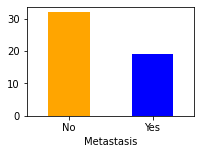

In [47]:
df_sts_tcia_cli_mets.plot.bar(x="Metastasis", y="Patients", rot=0, color=(
    "orange", "blue"), legend=None, figsize=(3, 2))